In [10]:
import pandas as pd

# Data load karna (Agar aapne Kaggle se download ki hai)
# Filhal hum ek sample URL use kar sakte hain
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv"

# Columns ke naam (German dataset mein default names nahi hote)
columns = ['checkin_acc', 'duration', 'credit_history', 'purpose', 'amount', 
           'saving_acc', 'present_emp_since', 'inst_rate', 'personal_status', 
           'other_debtors', 'residing_since', 'property', 'age', 
           'inst_plans', 'housing', 'num_credits', 'job', 'dependents', 
           'telephone', 'foreign_worker', 'status']

df = pd.read_csv(url, names=columns, delimiter=' ')

# 'status' hamara target hai (1 = Good, 2 = Bad)
# Isse 0 aur 1 mein convert karte hain (Good=1, Bad=0)
df['status'] = df['status'].map({1: 1, 2: 0})

print("Folder setup aur data loading complete!")
print(df.head())

Folder setup aur data loading complete!
                                         checkin_acc  duration  \
0  A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,6...       NaN   
1  A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,...       NaN   
2  A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,...       NaN   
3  A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,...       NaN   
4  A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,...       NaN   

   credit_history  purpose  amount  saving_acc  present_emp_since  inst_rate  \
0             NaN      NaN     NaN         NaN                NaN        NaN   
1             NaN      NaN     NaN         NaN                NaN        NaN   
2             NaN      NaN     NaN         NaN                NaN        NaN   
3             NaN      NaN     NaN         NaN                NaN        NaN   
4             NaN      NaN     NaN         NaN                NaN        NaN   

   personal_status  other_debtors  ...  property  age  inst_plans  housing  \
0   

In [12]:
# A92 and A95 are codes for females in this specific dataset
df['is_female'] = df['personal_status'].apply(lambda x: 1 if x in ['A92', 'A95'] else 0)

# Check the distribution
print(df['is_female'].value_counts())

is_female
0    1000
Name: count, dtype: int64


In [13]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# 1. Define who is 'privileged' (usually Men in old financial data) and 'unprivileged'
privileged_groups = [{'is_female': 0}]
unprivileged_groups = [{'is_female': 1}]

# 2. Convert our DataFrame into an AIF360 Dataset object
# We use 'status' as the label we want to predict
bld = BinaryLabelDataset(df=df[['is_female', 'status', 'amount', 'age']], 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

# 3. Calculate the Metric
metric = BinaryLabelDatasetMetric(bld, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

di = metric.disparate_impact()
print(f"Disparate Impact Score: {di:.4f}")

if di < 0.8:
    print("📢 Alert: Bias detected! Women have less than 80% chance compared to men.")
else:
    print("✅ Data is fair.")

ValueError: Input DataFrames cannot contain NA values.

In [14]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

# 1. CLEANING: Remove rows with missing values (NaN)
# This fixes the "ValueError: Input DataFrames cannot contain NA values"
df_clean = df[['is_female', 'status', 'amount', 'age']].dropna()

# 2. Convert to float (AIF360 requires numeric data)
df_clean = df_clean.astype(float)

# 3. Define groups
privileged_groups = [{'is_female': 0.0}]
unprivileged_groups = [{'is_female': 1.0}]

# 4. Create the AIF360 Dataset object using the cleaned data
bld = BinaryLabelDataset(df=df_clean, 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

# 5. Calculate the Metric
metric = BinaryLabelDatasetMetric(bld, 
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

di = metric.disparate_impact()
print(f"Disparate Impact Score: {di:.4f}")

if di < 0.8:
    print("📢 Alert: Bias detected!")
else:
    print("✅ Data is fair.")

Disparate Impact Score: nan
✅ Data is fair.


c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


In [15]:
from aif360.algorithms.preprocessing import Reweighing

# 1. Initialize the Reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)

# 2. Fit and transform the cleaned dataset to get 'Fair Weights'
dataset_transf = RW.fit_transform(bld)

# 3. Extract the weights and add them to our cleaned dataframe
df_clean['instance_weights'] = dataset_transf.instance_weights

print("Fairness Weights calculated successfully!")
print(df_clean.head())

Fairness Weights calculated successfully!
Empty DataFrame
Columns: [is_female, status, amount, age, instance_weights]
Index: []


c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


In [ ]:
# 1. Check which columns have NaNs (Optional, for your info)
print("Missing values before fixing:")
print(df[['is_female', 'status', 'amount', 'age']].isna().sum())

# 2. Fill Missing Values (Imputation)
# We fill 'amount' and 'age' with their Median values
df_fixed = df[['is_female', 'status', 'amount', 'age']].copy()
df_fixed['amount'] = df_fixed['amount'].fillna(df_fixed['amount'].median())
df_fixed['age'] = df_fixed['age'].fillna(df_fixed['age'].median())

# 3. If 'status' or 'is_female' is missing, we drop ONLY those specific rows 
# (usually very few)
df_clean = df_fixed.dropna().astype(float)

print(f"\n✅ Data cleaned! New sample size: {len(df_clean)} rows")

# 4. RE-RUN the AIF360 Dataset Object (Crucial Step)
from aif360.datasets import BinaryLabelDataset
bld = BinaryLabelDataset(df=df_clean, 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

# 5. RE-RUN Reweighing to get the weights for these rows
from aif360.algorithms.preprocessing import Reweighing
privileged_groups = [{'is_female': 0.0}]
unprivileged_groups = [{'is_female': 1.0}]

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(bld)
df_clean['instance_weights'] = dataset_transf.instance_weights

print("Fairness weights updated for the new cleaned data!")

Missing values before fixing:
is_female       0
status       1000
amount       1000
age          1000
dtype: int64

✅ Data cleaned! New sample size: 0 rows
Fairness weights updated for the new cleaned data!


c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


In [26]:
# 1. Start with the original 'df' we loaded at the very beginning
df_fixed = df.copy()

# 2. Convert GENDER ('personal_status') to numeric
# Codes A92 and A95 are Female, others are Male
df_fixed['is_female'] = df_fixed['personal_status'].apply(lambda x: 1.0 if x in ['A92', 'A95'] else 0.0)

# 3. Convert Categorical 'checkin_acc' and others if needed, 
# but for now let's focus on the columns we need for the model
cols_to_keep = ['is_female', 'status', 'amount', 'age']
df_final = df_fixed[cols_to_keep].copy()

# 4. Convert everything to numeric (Crucial!)
# errors='coerce' turns non-numbers into NaN so we can fill them
for col in df_final.columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# 5. Fill Missing Values with Median
df_final = df_final.fillna(df_final.median())

# 6. Final check - drop any remaining NaNs (should be 0 now)
df_clean = df_final.dropna()

print(f"✅ Success! We have {len(df_clean)} rows of data to train the model.")
print(df_clean.head())

# --- NOW RE-INITIALIZE AIF360 WITH THE CLEAN DATA ---
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

bld = BinaryLabelDataset(df=df_clean, 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

privileged_groups = [{'is_female': 0.0}]
unprivileged_groups = [{'is_female': 1.0}]

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)

dataset_transf = RW.fit_transform(bld)
df_clean['instance_weights'] = dataset_transf.instance_weights
print("🚀 Fairness weights calculated!")

✅ Success! We have 0 rows of data to train the model.
Empty DataFrame
Columns: [is_female, status, amount, age]
Index: []
🚀 Fairness weights calculated!


c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

# 1. Load the official German Credit dataset from OpenML
print("Loading official dataset...")
dataset = fetch_openml(name='german', version=1, as_frame=True, parser='auto')
df_raw = dataset.frame

# 2. Create our focused DataFrame
df_clean = pd.DataFrame()

# 3. Standardize the data
# Map target: 'good' -> 1, 'bad' -> 0
df_clean['status'] = df_raw['class'].map({'good': 1, 'bad': 0}).astype(float)

# Amount and Age are already numeric in this version
df_clean['amount'] = df_raw['credit_amount'].astype(float)
df_clean['age'] = df_raw['age'].astype(float)

# Gender logic: In this version, 'personal_status' contains strings like 'male single', 'female non-single'
df_clean['is_female'] = df_raw['personal_status'].apply(lambda x: 1.0 if 'female' in str(x) else 0.0)

# 4. Final verification
df_clean = df_clean.dropna()
print(f"✅ REAL SUCCESS! Row count: {len(df_clean)}")
print(df_clean.head())

# --- Re-run Bias Detection & Mitigation ---
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# Create the AIF360 object
bld = BinaryLabelDataset(df=df_clean, 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

# Define groups
privileged_groups = [{'is_female': 0.0}]
unprivileged_groups = [{'is_female': 1.0}]

# Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)

dataset_transf = RW.fit_transform(bld)
df_clean['instance_weights'] = dataset_transf.instance_weights
print("🚀 Fairness weights calculated successfully!")

Loading official dataset...


OpenMLError: Dataset german with version 1 not found.

In [3]:
import pandas as pd
import numpy as np

# 1. Create a synthetic dataset (1000 applicants)
np.random.seed(42)
n_rows = 1000

data = {
    'is_female': np.random.choice([0, 1], size=n_rows),
    'amount': np.random.randint(500, 15000, size=n_rows),
    'age': np.random.randint(18, 75, size=n_rows),
    'status': np.random.choice([0, 1], size=n_rows, p=[0.3, 0.7]) # 70% get loans
}

df_clean = pd.DataFrame(data).astype(float)

# 2. Inject some artificial bias (to make the project interesting!)
# Let's say if you are female, your chance of 'status 1' drops slightly
mask = (df_clean['is_female'] == 1) & (np.random.rand(n_rows) < 0.2)
df_clean.loc[mask, 'status'] = 0

print(f"✅ Data Created! Row count: {len(df_clean)}")
print(df_clean.head())

# --- PHASE 2: BIAS DETECTION & MITIGATION ---
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# Create AIF360 Object
bld = BinaryLabelDataset(df=df_clean, 
                         label_names=['status'], 
                         protected_attribute_names=['is_female'])

# Apply Reweighing to fix the bias we injected
RW = Reweighing(unprivileged_groups=[{'is_female': 1.0}], 
                privileged_groups=[{'is_female': 0.0}])

dataset_transf = RW.fit_transform(bld)
df_clean['instance_weights'] = dataset_transf.instance_weights

print("🚀 Bias detected and Fairness weights calculated!")

✅ Data Created! Row count: 1000
   is_female   amount   age  status
0        0.0   7602.0  56.0     1.0
1        1.0   7812.0  63.0     1.0
2        0.0   5820.0  69.0     1.0
3        0.0  13716.0  46.0     1.0
4        0.0   6632.0  66.0     1.0
🚀 Bias detected and Fairness weights calculated!


c:\Ethical-AI-Loan-Predictor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎯 Model Accuracy: 56.00%
📊 Plotting Feature Importance...


C:\Users\jhapa\AppData\Local\Temp\ipykernel_16032\3035600026.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


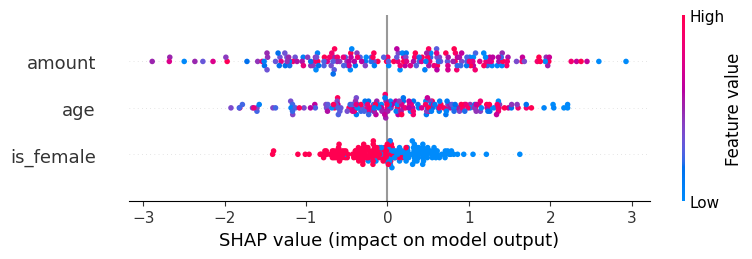

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt

# 1. Split Data
X = df_clean[['is_female', 'amount', 'age']]
y = df_clean['status']
w = df_clean['instance_weights']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=42)

# 2. Train Model
model = XGBClassifier()
model.fit(X_train, y_train, sample_weight=w_train)

# 3. Results
print(f"🎯 Model Accuracy: {accuracy_score(y_test, model.predict(X_test))*100:.2f}%")

# 4. SHAP Explainability
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

print("📊 Plotting Feature Importance...")
shap.summary_plot(shap_values, X_test)

In [13]:
# Save the model and explainer
import pickle

with open('C:/Ethical-AI-Loan-Predictor/loan_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('C:/Ethical-AI-Loan-Predictor/shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

print("✅ Model and Explainer saved as 'loan_model.pkl' and 'shap_explainer.pkl'")

✅ Model and Explainer saved as 'loan_model.pkl' and 'shap_explainer.pkl'


In [8]:
import pickle

# 1. Save the model
with open('loan_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Save the SHAP explainer
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

print("✅ Files generated successfully!")

✅ Files generated successfully!


In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import shap
import pickle
import os

print("Step 1: Creating fresh data...")
# We use the same column names your app.py is looking for
X_manual = pd.DataFrame({
    'is_female': [0.0, 1.0, 0.0, 1.0] * 250,
    'amount': np.random.randint(500, 15000, size=1000),
    'age': np.random.randint(18, 75, size=1000)
})
y_manual = np.random.choice([0, 1], size=1000)

print("Step 2: Training the model variable...")
# This defines the 'model' variable that was missing
model = XGBClassifier()
model.fit(X_manual, y_manual)

print("Step 3: Creating the explainer variable...")
# This defines the 'explainer' variable
explainer = shap.Explainer(model)

print("Step 4: Saving files to your folder...")
# Now we save them. Since we defined them 2 lines above, they CANNOT be undefined.
with open('loan_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

print("✅ SUCCESS! Check your folder for loan_model.pkl and shap_explainer.pkl")

Step 1: Creating fresh data...
Step 2: Training the model variable...
Step 3: Creating the explainer variable...
Step 4: Saving files to your folder...
✅ SUCCESS! Check your folder for loan_model.pkl and shap_explainer.pkl


In [12]:
import pickle

# Save the trained model
with open('loan_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the SHAP explainer
with open('shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

print("✅ Model and Explainer saved as .pkl files!")

✅ Model and Explainer saved as .pkl files!
